In [1]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.9 MB/s eta 0:00:00


## 1. Coder une architecture de LLM

Le terme paramètre, dans le contexte du DL et des LLMs, fait référence aux poids entraînables du modèle. Ces poids sont essentiellement les variables internes du modèle qui sont ajustés et optimisés durant l'entrainement pour minimiser une fonction de perte.
C'est cette optimisation qui permet au modèle d'apprendre à partir des données d'entrainement.

On va se concentrer sur GPT-2, plutôt que GPT-3, car les poids du modèle préentrainé sont ouverts.

GPT-3 est semblable en terme d'architecture, à part qu'il y a 1.5 milliard de paramètres dans GPT-2 pour 175 milliard dans GPT-3 et qu'il a été entrainé sur plus de données.

**Ca prendrait 355 annnées pour entrainer GPT-3 sur un GPU V100 et 655 années pour le faire sur un GPU RTX 8000.**

In [2]:
GPT_CONFIG_124M = {
  "vocab_size": 50257, # Vocabulary size
  "context_length": 1024, # Context length
  "emb_dim": 768, # Embedding dimension
  "n_heads": 12, # Number of attention heads
  "n_layers": 12, # Number of layers
  "drop_rate": 0.1, # Dropout rate
  "qkv_bias": False # Query-Key-Value bias
}

* *vocab_size* : vocabulaire de 50257 mots comme dans le tokenizer BPE
* *context_length* : nombre maximum de tokens en entrée que le modèle peut gérer avec le positional embeddings
* *emb_dim* : taille de l'mebedding, chaque token va être transformé en un vecteur de dimension 768.
* *n_heads* : nombre de attention heads pour le mécansime de multi-head attention
* *n_layers* : nombre de blocs transformer dans le modèle
* *drop_rate* : intensité du mécanisme de dropout pour prévenir de l'overfitting
* *qkv_bias* : est ce qu'il faut inclure un vecteur de biais dans les couches linéaires de la multi-head attention pour les calculs de query, key et value.

In [3]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self, cfg: dict):
    """Implémentation d'une architecture simplifié de GPT pour voir les blocs manquants."""
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
      *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
    cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
    torch.arange(seq_len, device=in_idx.device)
    )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    """Coquille vide pour le block transformer en attendant de le coder."""
    super().__init__()
  def forward(self, x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self, normalized_shape, eps=1e-5):
    """Coquille vide pour la couche de normalisation en attendant de le coder."""
    super().__init__()
  def forward(self, x):
    return x

In [4]:
# Création d'un bactch avec 2 textes en entrée
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
# Création d'une instance GPT simplifié et on lui fournit le batch
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


Le tensor en sortie a deux lignes qui correspondent aux deux textes en exemple. Chaque texte est constitué de 4 tokens et chaque token est un vecteur de dimension 50257.

L'embedding a 50257 dimensions car chaque dimension fait référence a un token unique dans le vocabulaire. Dans le code de postprocessing, on va convertir ces vecteurs de 50257 dimensions en ID de token, qu'on pourra ensuite décoder en mots.

## 2. Couche de normalisation

Entrainer un modèle de deep learning avec de nombreuses couches peut parfois provoquer des problèmes comme les gradients qui explosent ou disparaissent :
* **vanishing gradient** : les gradients utilisés pour mettre à jour les poids devienent extrêmement petit au fur et à mesure qu'ils sont rétropagagés à travers les couches du réseau. Cela peut entrainer un apprentissage lent, une convergence difficile et une saturation des fonctions d'activation
* **exploding gradient** : à l'inverse les gradients deviennent extrêmement grand au fur et à mesure qu'ils sont rétropropagés. Cela peut entrainer une instabilité de l'apprentissage.
Ces problèmes menent à un entrainement instable et ça rend difficile pour le modèle de mettre à jour ces poids efficacement.

On va implémenter une normalisation sur la couche (layer normalization) pour améliorer la stabilité et l'efficacité de l'entrainement du réseau de neurones.
L'idée de la normalisation sur les couches est d'ajuster les activations (les sorties) d'une couche pour avoir une moyenne de 0 et une variance de 1. Cela accélère la convergence vers des poids efficace et assure un entrainement fiable et constant.

Dans GPT-2, la 'layer normalization' est appliqué avant et après le module de multi-head attention et avant la couche de sortie finale.

In [6]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    """Implémentation d'un module de normalisation sur couche sur la dernière
      dimensions des tensors x (emb_dim).

    Les paramètres entraînables sclale et shift sont de la même dimension que
      l'entrée et vont être ajusté par le LLM durant l'entrainement si ça améliore
      les performances du modèle sur sa tâche d'entrainement.
    """
    super().__init__()
    self.eps = 1e-5  # petite variable pour éviter la division par 0
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    """Calcul des étapes pour la normalisation."""
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

In [7]:
# Test de normalisation sur couche
batch_example = torch.randn(2, 5)
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[ 3.5763e-08],
        [-2.3842e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


**Layer Normalization VS batch normalization** :
* La normalisation par batch est une méthode de normalisation commune pour les réseaux de neurones, cela permet de normaliser sur la dimension du batch.
* La normalisation par couche va normaliser sur la dimension des features.
* Les LLMs ont souvent besoin de ressources de calcul importante et le hardware disponible peut dicter la taille du batch durant l'entraibnement ou l'inférence. Comme la layer normalization normalise chaque entrée indépendamment du batch size, ça offre plus de flexibilité et de stabilité. C'est particulièrement bénéfique pour les entrainements distribués ou pour déployer des modèles dans des environnements avec ressources limitées.


## 3. Implémentation d'un réseau de propagation avant avec des activations GELU

Historiquemment;a l'activation ReLU a été souvent utilisé en DL grâce à sa simplicité et son efficacité sur de nombreuses architectures de réseau de neurone.

Pour les LLMs d'autres fonctions d'activation sont employées plutôt que ReLU comme GELU (Gaussian error linear unit) et SwiGLU (Swish-gated linear unit).  GELU et SwiGLU sont des fonctions d'activation plus complexe et lisse qui incorporant respectivement des unités linéaires gaussiennes et sigmoides. Elles offrent des performances amméliorées pour les modèles de DL par rapport à ReLU qui est plus simple.

In [8]:
class GELU(nn.Module):
  def __init__(self):
    """Implémentation d'une approcimation de GELU moins couteuse en calcul."""
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
      torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

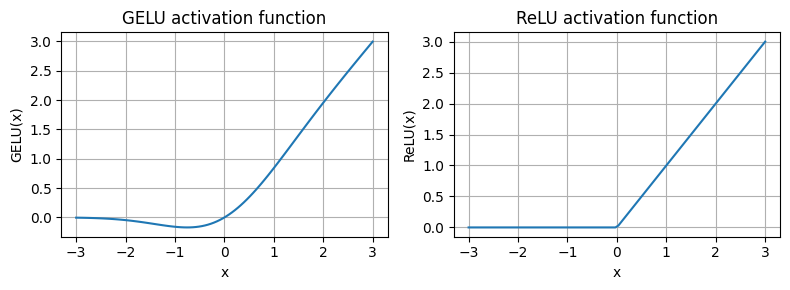

In [9]:
# Comparaison de GELU et ReLU
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
  plt.subplot(1, 2, i)
  plt.plot(x, y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)
plt.tight_layout()
plt.show()

* ReLU est une fonction linéaire par morceaux qui produit directement l'entrée si elle est positive ; sinon, elle produit zéro.
* GELU est une fonction non linéaire et fluide qui approxime ReLU mais avec un gradient non nul pour presque toutes les valeurs négatives (sauf à environ x = -0,75).

**La smoothness' de GELU peut mener à de meilleurs propriété pour l'optimisation durant l'entrainement, comme ça permet des ajustements plus nuancés aux paramètres du modèle.**

Au contraire, ReLU a un coin prononcé à 0, ce qui peut rendre l'optimisation plus dure, surtout pour les réseaux très profonds ou qui ont une architecture complexe.
De plus, contrairement à ReLU, qui donne 0 pour une entrée négative, GELU permet une petite valeurs différetes de 0 pour les entrées négatives. Cela permet, durant l'entrainement, que les neurones qui recoicvent une entrée négative continue de contribuer au processus d'apprentissage.


In [10]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
      GELU(),
      nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )
  def forward(self, x):
    return self.layers(x)

In [11]:
# test de la couche de feedforward
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)  # (batch, nb_tokens, emb_dim)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


Le module FeedForward joue un rôle crucial pour permettre au modèle d'apprendre et de généraliser à partir des données.

Même si les dimensions d'entrée et de sortie du module sont les mêmes, il augmente les dimensions de l'embedding dans un espace de plus haute dimension avec la plus première couche linéaire. La couche GELU permet d'ajouter de la non linéarité. De plus l'uniformité entre les dimensions d'entrée et de sortie simplifie l'architecture en permettant l'empillement de plusieurs couches.

## 4. Ajout de 'shortcut connections' ou 'residual connections' ou 'skip connections'

Le problème de 'vanishing gradient' fair référence au problème où les gradients (qui guide la mise à jour des poids durant l'entrainement) deviennt de plus en plus petit au fur et à mesure qu'ils reculent au travers des couches, ce qui rend difficile d'entrainer efficacement les premières couches.

Les connexions résiduelles vont créer une alternative, un chemin plus court pour le gradient pour parcourir le réseau en sautant une ou plusieurs couches.

Ca joue un rôle crucial pour préserver  le flux des gradients durant la phase de backward de l'entrainement.

In [12]:
# Réseau de neurones pour illustrer les connexions résiduelles
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
      nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
      GELU()),
      nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
      GELU()),
      nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
      GELU()),
      nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
      GELU()),
      nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
      GELU())
    ])

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x)
      if self.use_shortcut and x.shape == layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x

In [13]:
# Fonction qui calcul les gradients durant la l'étape de backward
def print_gradients(model, x):
  output = model(x)  # forward pass
  target = torch.tensor([[0.]])
  loss = nn.MSELoss()
  loss = loss(output, target)
  loss.backward()  # backward pass to calculate gradients
  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [14]:
# Chaque couche accepte un exemple avec 3 entrée et retourne 3 valeurs en sortie sauf la dernière
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

In [15]:
# Initalisation d'un réseau de neurones sans 'shortcut connections'
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
  layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


Les gradients deviennent plus petit au fur et à mesure qu'on progresse de la dernière couche à la première. C'est le problème de la disparition des gradients (vanishing gradient).

In [16]:
# Initialisation d'un réseau avec des 'skip connections'
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


La dernière couche a encore un gradient plus gros que les autres couches. Cependant la valeur du gradient se stabilise au fur et à mesure qu'on progresse vers la première couche.

En conclusion, les connexions résiduelles sont important pour résoudre les limitesposé par le problème des gradients qui disparaissent.

## 5. Connexion des couches d'attention et linéaires dans un bloc transformer

Ce bloc est repété 12 fois dans l'architecture GPT-2 de 124 millions de paramètres. Il couvre plusieurs concepts vus précédemment : multi-head attention, layer normlaization, dropout, feed forward layers et GELU activations.

Quand un bloc transformer traite une séquence d'entrée, chaque élément de la séquence  est représenté par un vecteur de taille fixe (ici 768 dimensions). Les opérations dans le bloc transfromer, comme la multi-head attention ou les couches feedforward, sont désignés pour transfromer ces vecteurs de façon à préserver leur dimenssionalité.

Le mécanisme de self-attention dans le block de multi-head attention identifie et analise les relations entre les éléments de la séquence d'entrée.

Le réseau de propagation avant modifie les données individuellement à chaque position. Cette combinaison permet une compréhenssion et un traitement de l'entrée plus nuancé, mais améliore aussi les capacités du modèle à gérer des patternes de données plus complexes.

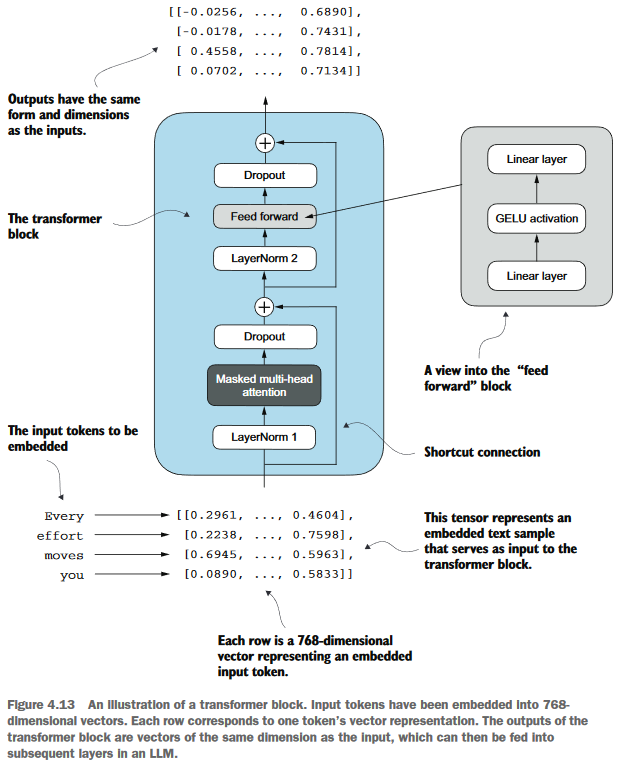

In [17]:
# On récupère la classe MultiHeadAttention codé précédemment
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    """Initialisation de la classe pour calculer la multi-head attention."""
    super().__init__()
    assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    # Réduit la dim de projection pour correspondre à la dim de sortie souhaité
    self.head_dim = d_out // num_heads
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    # Utilise une couche linéaire pour combiner les sorties des heads
    self.out_proj = nn.Linear(d_out, d_out)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
      "mask",
      torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    """Calcul de la multi-head attention."""
    b, num_tokens, d_in = x.shape

    # 1. Calcul des keys, querries, values
    keys = self.W_key(x)  # (batch, num_tokens, d_out)
    queries = self.W_query(x)
    values = self.W_value(x)

    # 2. Division des matrices en plusieurs heads
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)  # (batch, num_tokens, num_heads, head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
    keys = keys.transpose(1, 2)  # (batch, num_heads, num_tokens, head_dim)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    # 3. Calcul du score d'attention
    attn_scores = queries @ keys.transpose(2, 3)  # produit scalaire pour chaque tête

    # 4. Application du masque pour la causalité
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]  # Masque tronqué au nombre de tokens
    attn_scores.masked_fill_(mask_bool, -torch.inf)  #     # Utilise le masque sur les scores d'attention

    # 5. Calcul des poids d'attention
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    # 6. Calcul des vecteurs de context
    context_vec = (attn_weights @ values).transpose(1, 2)  # (batch, num_tokens, num_heads, head_dim)
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)  # Combinaison des heads avec d_out=num_heads*head_dim
    context_vec = self.out_proj(context_vec)  # Ajoute une proj linéaire optionelle
    return context_vec

In [18]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
      d_in=cfg["emb_dim"],
      d_out=cfg["emb_dim"],
      context_length=cfg["context_length"],
      num_heads=cfg["n_heads"],
      dropout=cfg["drop_rate"],
      qkv_bias=cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x  # Connexion résiduelle pour le bloc d'attention
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut  # Ajout de l'entrée originelle
    shortcut = x  # Connexion résiduelle pour le bloc de propagation avant
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut  # Ajout de l'entrée originelle
    return x

La layer normalisation est appliqué avant la multi-head attention et le feedforward.
Le dropout est appliqué après les deux blocs pour régulariser le modèle et prévénir l'overfitting.

On appelle aussi ça 'Pre-LayerNorm'. Les architectures plus anciennes, comme le modèle transfromer originel, appliquaient la layer normalization après la sef-attention et les réseaux feedforward, c'est la 'Post-LayerNorm'. Cela résulte souvent vers des dynamiques d'entrainement moins bonnes.

Chaque composant est suivi par une connection résiduelle qui ajoute l'entrée du bloc à sa sortie. Ca aide le flux des gradients au travers du réseau durant l'entrainement et améliore l'apprentissage des modèles profonds.

In [19]:
# Instanciation d'un bloc transformer
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


La préservation de la forme au travers ud block transformer est un aspect crucial de son design. Cela permet son application efficace sur un grand éventail de tâche Seq2Seq, où chauqe vecteur de sortie correspond à un vecteur d'entrée.

Cependant la sortie est un vecteur de contexte qui encapsule l'information à partir de toute la séquence d'entrée.

## 6. Coder le modèle GPT

Le bloc transformer est répété plusieurs fois au travers une architecture de modèle GPT. Dans le modèle GPT-2 124m, c'est répété 12 fois. Ce bloc transfromer est répété 48 fois dans le modèle GPT-2 le plus large de 1.5b paramètres.

La sortie du bloc transformer final va au travers d'une étape de layer normalisation finale avant d'atteindre une couche linéaire de sortie. Cette couche fait correpondre la sortie du transformer en un espace de haute dimension, qui correspond à la taille du vocabulaire du modèle, pour prédire le prochain token dans la séquence.

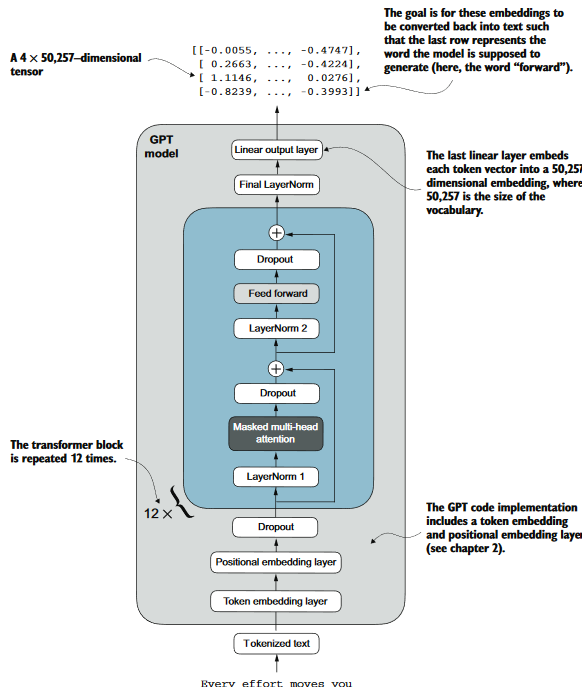

In [20]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
      *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)

    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [21]:
# Initialisation d'un modèle GPT à 124m
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [22]:
# Calcul du nombre de paramètres du modèle
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


**Pourquoi le modèle initialisé ne fait pas 124m de paramètres ?**

La raison est un concepte appelé 'weigth tying' qui a été utilisé dans l'architecture de GPT-2. L'architecture originelle de GPT-2 réutilise les poids de la couche d'embedding des tokens dans sa couche de sortie.

In [23]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [24]:
# En enlevant les paramètres de la couche de sortie du compte
total_params_gpt2 = (
  total_params - sum(p.numel() for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
  f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


Comme on peut le voir, le modèle est maintenant seulement de 124m paramètres ce qui correspond à la taille originelle du modèle GPT-2.

Le partage de poids ('Weight tying') réduit l'empreinte mémoire globale et la complexité en calcul du modèle.

Cependant utiliser des embeddings de tokens et une couche de sortie différente peut donner un meilleur entrainement et de meilleurs performances. les LLMs modernes utilise des couches différentes dans leur implémentation.

In [25]:
# Calcul la mémoire nécessaire pour le modèle a 163 million de paramètres
total_size_bytes = total_params * 4  # on garde le float32
total_size_mb = total_size_bytes / (1024 * 1024)  # on convertit en megabytes
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## 7. Génération de texte

**Comment un modèle GPT passe de tensors de sortie (batch_size, num_token, vocab_size) à un texte généré ?**

1. A chaque étape, le modèle sort une matrice avec des vecteurs représentant les prochains tokens potentiels.
2. Le vecteur correspondant au prochain token est extrait et converti en une distribution de probabilité avec une fonction softmax.
3. Dans le vecteur avec les scores de probabilités obtenus, l'index de la valeur la plus haute est localisé , ce qui donne le token ID.
4. Ce token ID est ensuite décodé en texte, ce qui produit le prochain token de la séquence.
5. On ajoute ensuite ce token aux entrées précédentes pour former une nouvelle séquence pour l'ittération suivante.

Ce processus ittératif permet au modèle de générer du texte de façon séquentiel en construisant des phrases cohérentes.

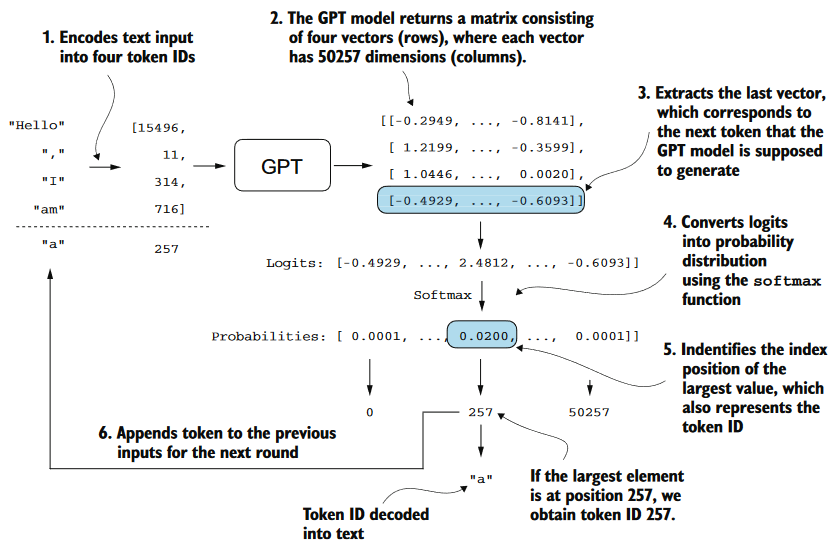



In [30]:
# Fonction pour que le modèle GPT génère du texte
def generate_text_simple(model, idx, max_new_tokens, context_size):
  """idx (batch, n_tokens) : tableau d'indices dans le contexte actuel"""
  for _ in range(max_new_tokens):
    # On coupe le contexte si ça dépasse la limite de la taille de contexte du LLM
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    # On garde que la dernière ittérattion : (batch, n_token, vocab)->(batch, vocab)
    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)
    # On ajoute les nouveau indexs du batch
    idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)
  return idx

Ce code démontre une implémentation basique d'une boucle générative pour un LLM. Ca ittère pour un nombre de tokens spécifiques à générer, coupe le contexte actuel pour corespondre à la taille de contexte maximum du modèle, calcul les prédictions et choisis ensuite le prochain token selon la prédiction avec la probabilité la plus haute.

Cette approche pour que le modèle génère le prochain token le plus probable est aussi apellé 'greedy decoding'.

In [28]:
# Essai de la focntion pour générer du texte
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Ajout de la dim du batch
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [31]:
# On met le modèle en mode eval : désactive le dropout
model.eval()
out = generate_text_simple(
  model=model,
  idx=encoded_tensor,
  max_new_tokens=6,
  context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [32]:
# On retransforme les tokens ID en text
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


Le modèle n'est pas capable de fournir du texte cohérent comme il n'a pas été entrainé encore.